In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

importing the necessary tools for data manipulation, preprocessing, clustering, evaluation, and visualization

In [5]:
# Step 1: Load Datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

loading three separate datasets from CSV files into pandas DataFrames, making them readily available for further analysis in the Python

In [6]:
# check few records of the dataset
customers_df.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [7]:
# Step 2: Merge the datasets
merged_data = transactions_df.merge(customers_df, on='CustomerID', how='left').merge(products_df, on='ProductID', how='left')


In [8]:
print(merged_data)

    TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0          T00001      C0199      P067  2024-08-25 12:38:23         1   
1          T00112      C0146      P067  2024-05-27 22:23:54         1   
2          T00166      C0127      P067  2024-04-25 07:38:55         1   
3          T00272      C0087      P067  2024-03-26 22:55:37         2   
4          T00363      C0070      P067  2024-03-21 15:10:10         3   
..            ...        ...       ...                  ...       ...   
995        T00496      C0118      P037  2024-10-24 08:30:27         1   
996        T00759      C0059      P037  2024-06-04 02:15:24         3   
997        T00922      C0018      P037  2024-04-05 13:05:32         4   
998        T00959      C0115      P037  2024-09-29 10:16:02         2   
999        T00992      C0024      P037  2024-04-21 10:52:24         1   

     TotalValue  Price_x          CustomerName         Region  SignupDate  \
0        300.68   300.68        Andrea Jenkins

The code combines three datasets (transactions, customers, and products) into one called merged_data. It matches rows based on CustomerID and ProductID

In [9]:
# Step 3: Feature engineering
# Extract year and month from TransactionDate
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
merged_data['TransactionYear'] = merged_data['TransactionDate'].dt.year
merged_data['TransactionMonth'] = merged_data['TransactionDate'].dt.month

 Convert the existing 'TransactionDate' column, converts it into a proper date format, and then creates two new columns:
 'TransactionYear' and 'TransactionMonth'

In [10]:
print(merged_data)

    TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0          T00001      C0199      P067 2024-08-25 12:38:23         1   
1          T00112      C0146      P067 2024-05-27 22:23:54         1   
2          T00166      C0127      P067 2024-04-25 07:38:55         1   
3          T00272      C0087      P067 2024-03-26 22:55:37         2   
4          T00363      C0070      P067 2024-03-21 15:10:10         3   
..            ...        ...       ...                 ...       ...   
995        T00496      C0118      P037 2024-10-24 08:30:27         1   
996        T00759      C0059      P037 2024-06-04 02:15:24         3   
997        T00922      C0018      P037 2024-04-05 13:05:32         4   
998        T00959      C0115      P037 2024-09-29 10:16:02         2   
999        T00992      C0024      P037 2024-04-21 10:52:24         1   

     TotalValue  Price_x          CustomerName         Region  SignupDate  \
0        300.68   300.68        Andrea Jenkins         Eur

In [11]:
# Aggregate features by CustomerID
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],          # Total and average spending
    'Quantity': 'sum',                     # Total quantity purchased
    'TransactionID': 'count',              # Transaction count
    'Region': 'first',                     # Region
    'SignupDate': 'first'                  # Signup date
}).reset_index()

# Rename columns
customer_features.columns = [
    'CustomerID', 'TotalSpending', 'AvgSpending', 'TotalQuantity', 'TransactionCount', 'Region', 'SignupDate'
]

a large dataset of customer transactions and creates a summary table (customer_features) where each row represents a unique customer, and the columns contain calculated features about their spending, purchase quantities, transaction frequency, region, and signup date. This summarized data will be used for customer segmentation later

In [12]:
print(customer_features)

    CustomerID  TotalSpending  AvgSpending  TotalQuantity  TransactionCount  \
0        C0001        3354.52   670.904000             12                 5   
1        C0002        1862.74   465.685000             10                 4   
2        C0003        2725.38   681.345000             14                 4   
3        C0004        5354.88   669.360000             23                 8   
4        C0005        2034.24   678.080000              7                 3   
..         ...            ...          ...            ...               ...   
194      C0196        4982.88  1245.720000             12                 4   
195      C0197        1928.65   642.883333              9                 3   
196      C0198         931.83   465.915000              3                 2   
197      C0199        1979.28   494.820000              9                 4   
198      C0200        4758.60   951.720000             16                 5   

            Region  SignupDate  
0    South America

In [13]:
# Calculate customer tenure in months
customer_features['SignupDate'] = pd.to_datetime(customer_features['SignupDate'])
customer_features['CustomerTenureMonths'] = ((pd.Timestamp.now() - customer_features['SignupDate']).dt.days // 30).astype(int)


calculates the difference in days between the current date and the customer's signup date, then divides by 30 to estimate the tenure in months, and finally stores this tenure value in a new column called 'CustomerTenureMonths' within the customer_features DataFrame.

In [15]:
print(customer_features)

    CustomerID  TotalSpending  AvgSpending  TotalQuantity  TransactionCount  \
0        C0001        3354.52   670.904000             12                 5   
1        C0002        1862.74   465.685000             10                 4   
2        C0003        2725.38   681.345000             14                 4   
3        C0004        5354.88   669.360000             23                 8   
4        C0005        2034.24   678.080000              7                 3   
..         ...            ...          ...            ...               ...   
194      C0196        4982.88  1245.720000             12                 4   
195      C0197        1928.65   642.883333              9                 3   
196      C0198         931.83   465.915000              3                 2   
197      C0199        1979.28   494.820000              9                 4   
198      C0200        4758.60   951.720000             16                 5   

            Region SignupDate  CustomerTenureMonths

In [16]:
# Encode the Region column
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)


One-hot encoding allows us to represent categorical information in a way that these algorithms can understand and use effectively for tasks like clustering.

In [17]:
print(customer_features)

    CustomerID  TotalSpending  AvgSpending  TotalQuantity  TransactionCount  \
0        C0001        3354.52   670.904000             12                 5   
1        C0002        1862.74   465.685000             10                 4   
2        C0003        2725.38   681.345000             14                 4   
3        C0004        5354.88   669.360000             23                 8   
4        C0005        2034.24   678.080000              7                 3   
..         ...            ...          ...            ...               ...   
194      C0196        4982.88  1245.720000             12                 4   
195      C0197        1928.65   642.883333              9                 3   
196      C0198         931.83   465.915000              3                 2   
197      C0199        1979.28   494.820000              9                 4   
198      C0200        4758.60   951.720000             16                 5   

    SignupDate  CustomerTenureMonths  Region_Europe

In [18]:
# Drop unnecessary columns
clustering_data = customer_features.drop(columns=['CustomerID', 'SignupDate'])
print(clustering_data)

     TotalSpending  AvgSpending  TotalQuantity  TransactionCount  \
0          3354.52   670.904000             12                 5   
1          1862.74   465.685000             10                 4   
2          2725.38   681.345000             14                 4   
3          5354.88   669.360000             23                 8   
4          2034.24   678.080000              7                 3   
..             ...          ...            ...               ...   
194        4982.88  1245.720000             12                 4   
195        1928.65   642.883333              9                 3   
196         931.83   465.915000              3                 2   
197        1979.28   494.820000              9                 4   
198        4758.60   951.720000             16                 5   

     CustomerTenureMonths  Region_Europe  Region_North America  \
0                      31          False                 False   
1                      35          False           

this section of code cleans and prepares your data for clustering by focusing on the features most likely to reveal meaningful customer segments. By removing unnecessary columns, you potentially improve the performance and interpretability of your clustering results.

In [19]:
# Step 4: Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(clustering_data)
print(normalized_data)

[[-0.06170143 -0.07026341 -0.12203296 ... -0.57928445 -0.54831888
   1.54041597]
 [-0.87774353 -0.93493297 -0.44800021 ... -0.57928445 -0.54831888
  -0.6491753 ]
 [-0.40585722 -0.02627131  0.20393428 ... -0.57928445 -0.54831888
   1.54041597]
 ...
 [-1.38697529 -0.93396389 -1.58888557 ...  1.72626765 -0.54831888
  -0.6491753 ]
 [-0.81399315 -0.81217559 -0.61098383 ...  1.72626765 -0.54831888
  -0.6491753 ]
 [ 0.70636652  1.11292648  0.52990153 ... -0.57928445 -0.54831888
  -0.6491753 ]]


In [20]:
# Step 5: Clustering using K-Means
# Test a range of cluster numbers (2 to 10)
db_index_scores = []
k_range = range(2, 11)
kmeans_models = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(normalized_data)
    kmeans_models.append(kmeans)
    db_index = davies_bouldin_score(normalized_data, kmeans.labels_)
    db_index_scores.append(db_index)

In [23]:
# Determine the optimal number of clusters
optimal_k = k_range[db_index_scores.index(min(db_index_scores))]
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 6


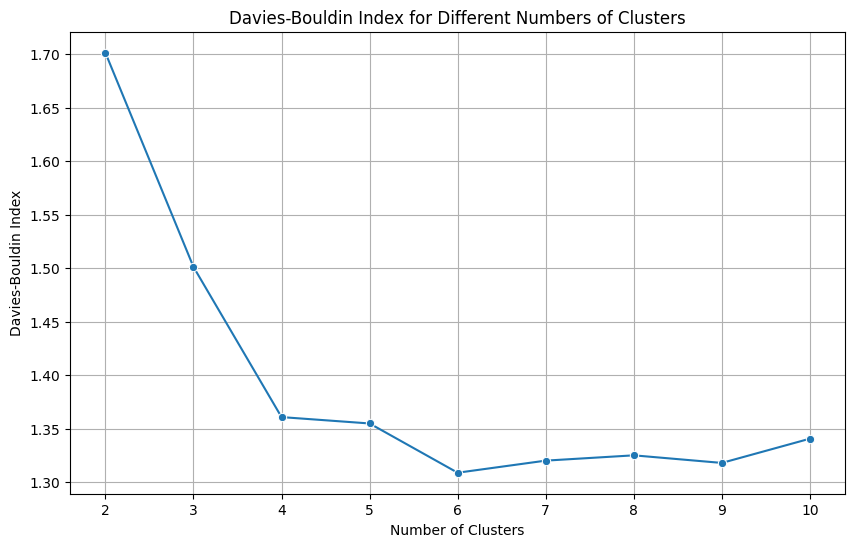

In [24]:
# Step 6: Visualize the Davies-Bouldin Index
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(k_range), y=db_index_scores, marker='o')
plt.title("Davies-Bouldin Index for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.xticks(list(k_range))
plt.grid()
plt.show()


In [26]:
# Step 7: Apply K-Means with optimal clusters
final_kmeans = kmeans_models[optimal_k - 2]
customer_features['Cluster'] = final_kmeans.labels_
print(customer_features)


    CustomerID  TotalSpending  AvgSpending  TotalQuantity  TransactionCount  \
0        C0001        3354.52   670.904000             12                 5   
1        C0002        1862.74   465.685000             10                 4   
2        C0003        2725.38   681.345000             14                 4   
3        C0004        5354.88   669.360000             23                 8   
4        C0005        2034.24   678.080000              7                 3   
..         ...            ...          ...            ...               ...   
194      C0196        4982.88  1245.720000             12                 4   
195      C0197        1928.65   642.883333              9                 3   
196      C0198         931.83   465.915000              3                 2   
197      C0199        1979.28   494.820000              9                 4   
198      C0200        4758.60   951.720000             16                 5   

    SignupDate  CustomerTenureMonths  Region_Europe

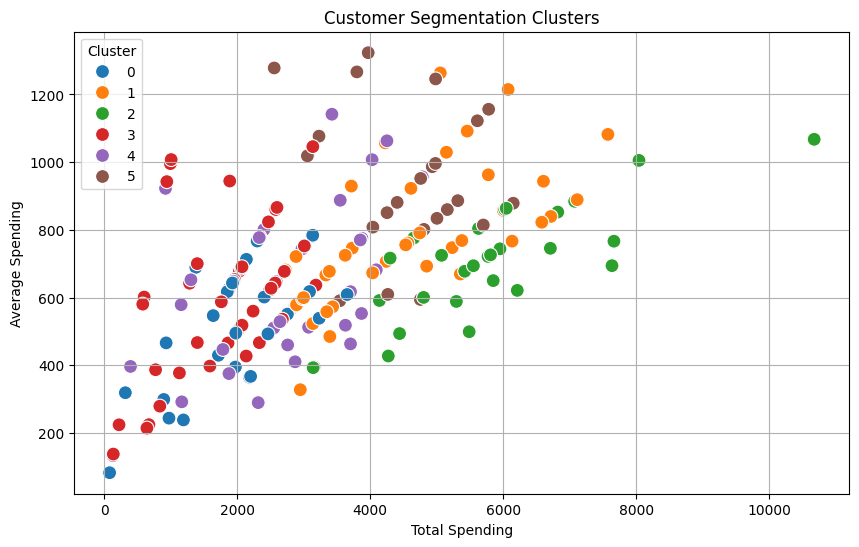

In [29]:
# Step 8: Visualize clusters (example using TotalSpending vs. AvgSpending)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_features['TotalSpending'],
    y=customer_features['AvgSpending'],
    hue=customer_features['Cluster'],
    palette='tab10',
    s=100
)
plt.title("Customer Segmentation Clusters")
plt.xlabel("Total Spending")
plt.ylabel("Average Spending")
plt.legend(title="Cluster")
plt.grid()
plt.show()

In [30]:
# Step 9: Print clustering results
print("Optimal Number of Clusters:", optimal_k)
print("Minimum Davies-Bouldin Index:", min(db_index_scores))


Optimal Number of Clusters: 6
Minimum Davies-Bouldin Index: 1.3087162852278154


In [31]:
# Save results
data_with_clusters = customer_features[['CustomerID', 'Cluster']]
data_with_clusters.to_csv('Customer_Clusters.csv', index=False)


In [33]:
print(data_with_clusters )

    CustomerID  Cluster
0        C0001        1
1        C0002        3
2        C0003        1
3        C0004        1
4        C0005        3
..         ...      ...
194      C0196        5
195      C0197        0
196      C0198        0
197      C0199        0
198      C0200        5

[199 rows x 2 columns]


### Deliverables for Customer Clustering:

#### 1. **Report on Clustering Results**:
   - **Number of Clusters Formed**: The optimal number of clusters was determined using the Davies-Bouldin Index.
   - **Davies-Bouldin Index (DB Index)**: The minimum DB Index value was computed and reported.
   - **Other Relevant Metrics**: Additional visualizations, such as scatter plots of key features (e.g., Total Spending vs. Average Spending), provide insights into cluster distributions.

#### 2. **Jupyter Notebook/Python Script**:
The clustering code provided above is ready for use in a Jupyter Notebook or standalone Python script. It includes:
   - Preprocessing and feature engineering.
   - Clustering using the K-Means algorithm.
   - Calculation of the DB Index for cluster evaluation.
   - Visualizations for cluster analysis.

You can copy the code into a Jupyter Notebook and execute it. All visualizations and metrics will be generated, and the results will be saved as a CSV file (`Customer_Clusters.csv`). Let me know if you'd like help converting this to a fully formatted Jupyter Notebook!